In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [344]:
data = pd.read_csv('TSLA.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400


In [345]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2951,2022-03-18,905.390015
2952,2022-03-21,921.159973
2953,2022-03-22,993.979980
2954,2022-03-23,999.109985


In [346]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-347-eef3cfff9d19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


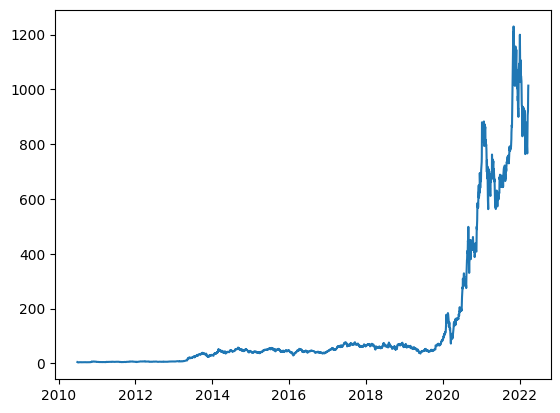

In [347]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [348]:
from copy import deepcopy as dc

def prepare_df_lstm(df, n_steps):
  df = dc(df)
  df.set_index('Date', inplace=True)
  for i in range(1, n_steps+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)
  df.dropna(inplace=True)
  return df

lookback = 7
shifted_df = prepare_df_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2010-07-09,3.480000,3.492000,3.160000,3.222000,3.840000,4.392000,4.766000,4.778000
2010-07-12,3.410000,3.480000,3.492000,3.160000,3.222000,3.840000,4.392000,4.766000
2010-07-13,3.628000,3.410000,3.480000,3.492000,3.160000,3.222000,3.840000,4.392000
2010-07-14,3.968000,3.628000,3.410000,3.480000,3.492000,3.160000,3.222000,3.840000
2010-07-15,3.978000,3.968000,3.628000,3.410000,3.480000,3.492000,3.160000,3.222000
...,...,...,...,...,...,...,...,...
2022-03-18,905.390015,871.599976,840.229980,801.890015,766.369995,795.349976,838.299988,858.969971
2022-03-21,921.159973,905.390015,871.599976,840.229980,801.890015,766.369995,795.349976,838.299988
2022-03-22,993.979980,921.159973,905.390015,871.599976,840.229980,801.890015,766.369995,795.349976


In [349]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[   3.48    ,    3.492   ,    3.16    , ...,    4.392   ,
           4.766   ,    4.778   ],
       [   3.41    ,    3.48    ,    3.492   , ...,    3.84    ,
           4.392   ,    4.766   ],
       [   3.628   ,    3.41    ,    3.48    , ...,    3.222   ,
           3.84    ,    4.392   ],
       ...,
       [ 993.97998 ,  921.159973,  905.390015, ...,  801.890015,
         766.369995,  795.349976],
       [ 999.109985,  993.97998 ,  921.159973, ...,  840.22998 ,
         801.890015,  766.369995],
       [1013.919983,  999.109985,  993.97998 , ...,  871.599976,
         840.22998 ,  801.890015]])

In [350]:
shifted_df_as_np.shape

(2949, 8)

In [351]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99988585, -0.99986629, -1.        , ..., -0.99799144,
        -0.9973817 , -0.99736214],
       [-1.        , -0.99988585, -0.99945873, ..., -0.99889138,
        -0.99799144, -0.9973817 ],
       [-0.99964452, -1.        , -0.9994783 , ..., -0.99989892,
        -0.99889138, -0.99799144],
       ...,
       [ 0.61527917,  0.49653477,  0.47092723, ...,  0.3021887 ,
         0.24427956,  0.29152632],
       [ 0.62364445,  0.61527917,  0.49663737, ...,  0.36469526,
         0.3021887 ,  0.24427956],
       [ 0.64779446,  0.62364445,  0.61535757, ...,  0.41583852,
         0.36469526,  0.3021887 ]])

In [352]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
X.shape, y.shape

((2949, 7), (2949,))

In [353]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99736214, -0.9973817 , -0.99799144, ..., -0.99989892,
        -1.        , -0.99986629],
       [-0.9973817 , -0.99799144, -0.99889138, ..., -1.        ,
        -0.99945873, -0.99988585],
       [-0.99799144, -0.99889138, -0.99989892, ..., -0.99945873,
        -0.9994783 , -1.        ],
       ...,
       [ 0.29152632,  0.24427956,  0.3021887 , ...,  0.41583852,
         0.47092723,  0.49653477],
       [ 0.24427956,  0.3021887 ,  0.36469526, ...,  0.47092723,
         0.49663737,  0.61527917],
       [ 0.3021887 ,  0.36469526,  0.41583852, ...,  0.49663737,
         0.61535757,  0.62364445]])

In [354]:
split_index = int(len(X) * 0.95)
split_index

2801

In [355]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2801, 7), (148, 7), (2801,), (148,))

In [356]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2801, 7, 1), (148, 7, 1), (2801, 1), (148, 1))

In [357]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2801, 7, 1]),
 torch.Size([148, 7, 1]),
 torch.Size([2801, 1]),
 torch.Size([148, 1]))

In [358]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [359]:
train_dataset

In [360]:
from torch.utils.data import DataLoader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [361]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [362]:
class LSTM(nn.Module):

  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [363]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [364]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [365]:
learning_rate = 0.02
num_epochs = 7
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.031

Val Loss: 0.073
***************************************************

Epoch: 2
Batch 100, Loss: 0.000

Val Loss: 0.051
***************************************************

Epoch: 3
Batch 100, Loss: 0.000

Val Loss: 0.020
***************************************************

Epoch: 4
Batch 100, Loss: 0.000

Val Loss: 0.025
***************************************************

Epoch: 5
Batch 100, Loss: 0.001

Val Loss: 0.016
***************************************************

Epoch: 6
Batch 100, Loss: 0.000

Val Loss: 0.011
***************************************************

Epoch: 7
Batch 100, Loss: 0.000

Val Loss: 0.013
***************************************************



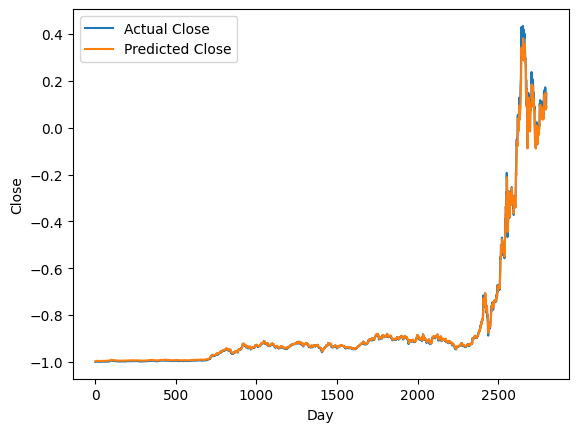

In [366]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [367]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  5.49744299,   5.51498822,   5.48713517, ..., 674.00427793,
       667.64541367, 670.33034463])

In [368]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  3.47999813,   3.41      ,   3.6279994 , ..., 673.46997104,
       680.26000917, 706.29999055])

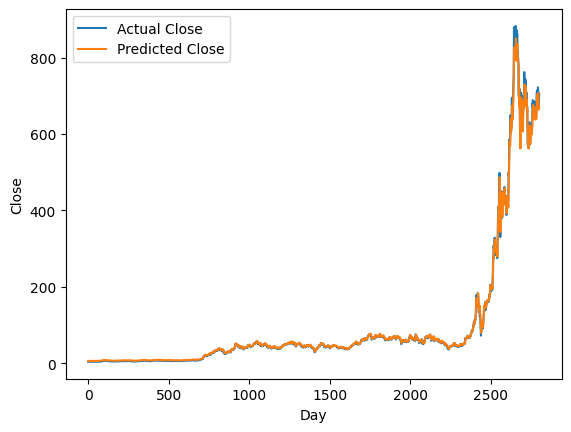

In [369]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [370]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 689.12617728,  696.82524076,  700.55407599,  694.53536975,
        699.49566037,  713.77191649,  721.64306938,  722.82872442,
        721.72238841,  721.95237705,  734.46153672,  739.39536329,
        741.40027063,  729.82265268,  730.08206612,  731.437325  ,
        739.24940896,  742.68966181,  745.24541606,  726.92169614,
        726.55638997,  735.04381884,  739.22747743,  753.44400669,
        768.52997489,  765.16926039,  765.80596925,  762.37861945,
        760.98399348,  764.47808823,  765.19630927,  766.7136056 ,
        773.80659126,  771.36601409,  774.2479633 ,  783.51732431,
        789.94370113,  796.29101478,  812.41986376,  832.83698474,
        837.15215941,  839.30492181,  854.82016315,  868.57251158,
        924.53201572,  944.11482476,  959.69052402,  981.09109134,
       1002.94805379, 1040.98990028, 1046.50875041, 1060.95037026,
       1071.87870528, 1074.45185855, 1058.63001442, 1002.04864176,
        996.35762913,  992.29452084,  978.24649883,  964.21580

In [371]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 708.48999086,  711.20001515,  701.15997105,  711.91998157,
        730.90997223,  735.7199679 ,  734.09002575,  732.39001237,
        733.57001091,  752.9199802 ,  753.86999924,  754.85998849,
        736.2700198 ,  743.00000209,  744.48999366,  755.83002004,
        756.98998779,  759.48999026,  730.16998414,  739.38000208,
        751.94000635,  753.6400106 ,  774.39000651,  791.35998448,
        777.5599898 ,  781.30998895,  775.47998525,  775.21996869,
        781.5300353 ,  780.59003166,  782.74999491,  793.60997666,
        785.48999229,  791.94000034,  805.71996422,  811.08001179,
        818.32001181,  843.03002867,  870.10998491,  864.27002064,
        865.79998243,  894.00000016,  909.68000212, 1024.85999127,
       1018.42999575, 1037.85997858, 1077.04003491, 1113.99999905,
       1208.58995539, 1172.00001271, 1213.85999231, 1229.910034  ,
       1222.08998158, 1162.9399516 , 1023.50001712, 1067.94996416,
       1063.50999909, 1033.42005006, 1013.39002058, 1054.72996

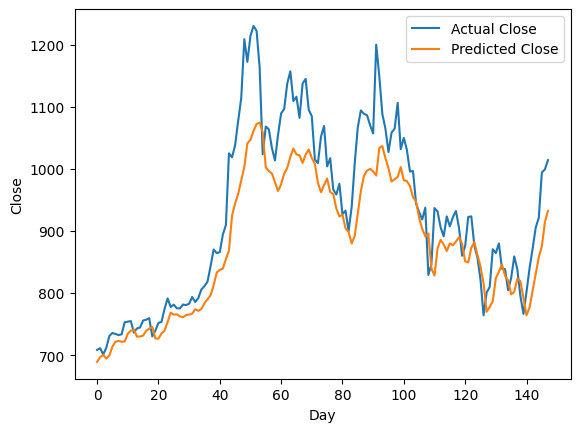

In [372]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
